In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
warnings.filterwarnings('ignore')

from synthesize import placeRandomRooms, synthesize_train_set, synthetic_sensor
from planning_utils import create_classification_problem, get_path, plot_path

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import random
from copy import deepcopy
import math
from shapely.geometry import LineString
from gridmap import OccupancyGridMap

In [50]:
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}
inv_dirs = {d: label for label, d in dirs.items()}


map_size = (50,50)
MAPS = []
n_rand = 10
n_runs = 100
pol = True
num_sensor_readings = 360

for i in range(n_rand):
    train_arr, train_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 4, attempts = 100)
    MAPS.append((train_MAP,train_arr))

In [51]:
df_ = synthesize_train_set(MAPS, num_runs = n_runs, polar=pol, num_sensor_readings=num_sensor_readings, robot_type = 'omni')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:25<00:00, 11.05s/it]


In [52]:
df = create_classification_problem(df_.copy(), num_sensor_readings)

In [53]:
# print(cross_val_score(RandomForestClassifier(n_estimators=200, class_weight={0:10, 1:10, 2:10}), df.drop(['out'], axis=1).values, df['out'].values, cv=10, scoring = 'accuracy'))

# Fit model using all data.
clf = RandomForestClassifier(n_estimators=200)
clf.fit(df.drop(['out'], axis=1).values, df['out'].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
from copy import deepcopy
'''
Testing Env:

Now we use trained model to nav unseen map. 
'''

# Mapping from label encoder (just hard coded it here)
dirs = {0:(1.0, 0.0), 1:(0.0, 1.0), 2:(-1.0, 0.0), 3:(0.0, -1.0)}
steer = {0:0, 1:np.pi/2., 2:-np.pi/2}

def test_ddr(_MAP, test_arr, start, goal, model, polar=False):
    
    # Get ground-truth path
    groud_truth = get_path(start, goal, test_arr) 
    print("Number of steps taken in A* Path, ", len(groud_truth))
    
    # i counter just helps stop after a certain number of steps since
    # at the moment the algorithm probably wont reach the goal. 
    i=0
    # Start saving the path traveled
    pred_path = [start]
    cur_dir = (0, 0) # Get robot direction
    
    cur = start
    recent_states = []
    dirs = []
    while cur != goal:
        try:
            
            laser_scan, lines = synthetic_sensor(_MAP, (cur[0]+0.5, cur[1]+0.5), direction=cur_dir)
            # Get rotation 
            offset = 0
            if cur_dir != (0, 0): # Start node
                offset = inv_dirs[cur_dir]
            rot = np.pi/2 * offset 
            # Get goal in odom
            goal_loc = (goal[0]-cur[0], goal[1]-cur[1])  
            # Get goal in odom
            goal_orn = (goal_loc[0]*np.cos(rot) + goal_loc[1]*np.sin(rot), goal_loc[0]*-np.sin(rot) + goal_loc[1]*np.cos(rot))
            if polar:
                # Get polar distance
                polar_distance = np.linalg.norm(np.array([goal_loc[0],goal_loc[1]]))
                # Get polar rotation
                polar_rotation = math.atan2(goal_orn[1], goal_orn[0])
                laser_scan.append(polar_distance)
                laser_scan.append(polar_rotation)
            else:
                laser_scan.append(goal_orn[0])
                laser_scan.append(goal_orn[1])

            # Create model input
            inpX = np.array(laser_scan)
            inds = model.predict_proba(inpX.reshape(1,-1))[0]
            best = list(np.argsort(inds))  
            best.reverse()

            possible_steers = [(np.cos(rot + steer[ind]), np.sin(rot + steer[ind])) for ind in best]
            possible_next_states = [(cur[0] + steers[0], cur[1] + steers[1]) for steers in possible_steers]

            temp_states = deepcopy(possible_next_states)
            for state in possible_next_states:
                if (-1 in state) or (50 in state) or (0 in state) or (state in pred_path):
                    temp_states.remove(state) 

            dirs.append(cur_dir)
            cur_dir = (temp_states[0][0] - cur[0], temp_states[0][1] - cur[1])
            cur = temp_states[0]
            
#             assert cur not in pred_path
            
            pred_path.append(cur)
            

            
            i+=1
            if cur == goal or i==50:
                print("found goal")
                break

#             
        except:
            break
    
    return pred_path, dirs
    

In [55]:
dirs = {0:(-1.0, 0.0), 1:(0.0, -1.0), 2:(0.0, 1.0), 3:(1.0, 0.0)}

def test_omni(_MAP, test_arr, start, goal, model):
    
    # Get ground-truth path
    groud_truth = get_path(start, goal, test_arr) 
    print("Number of steps taken in A* Path, ", len(groud_truth))
    
    # i counter just helps stop after a certain number of steps since
    # at the moment the algorithm probably wont reach the goal. 
    i=0
    # Start saving the path traveled
    pred_path = [start]  
    cur = start
    success = 0
    while cur != goal:
#         try:
        laser_scan, lines = synthetic_sensor(_MAP, (cur[0]+0.5, cur[1]+0.5), direction=None, num_sensor_readings=360, robot_type = 'omni')
        # Get goal in odom
        goal_loc = (goal[0]-cur[0], goal[1]-cur[1])  
        # Get goal in odom
        laser_scan.append(goal_loc[0])
        laser_scan.append(goal_loc[1])

        # Create model input
        inpX = np.array(laser_scan)
        inds = model.predict_proba(inpX.reshape(1,-1))[0]
        best = list(np.argsort(inds))  
        best.reverse()

        possible_next_states = [(cur[0] + dirs[ind][0], cur[1] + dirs[ind][1]) for ind in best]
        temp_states = deepcopy(possible_next_states)
        for state in possible_next_states:
            if (-1 in state) or (50 in state) or (0 in state) or (state in pred_path):
                temp_states.remove(state)

        # Update state
        cur = temp_states[0]
#         print(cur)
        assert cur not in pred_path
#         if test_arr[int(cur[0]), int(cur[1])] == 1:
#             print("HIT")
#             break
        pred_path.append(cur)
        # Cout number of steps traveled 
        i+=1
        if cur == goal:
            temp = [(p[0]+0.5, p[1]+0.5) for p in pred_path]
            if LineString(temp).intersects(_MAP):
#                 print("HITT")
                success = 0
            else:
                success = 1
                
            break
     
#         except:
#             break

    return pred_path, dirs, success, groud_truth
    

In [56]:
print("JO")

JO


In [57]:
from shapely.geometry import MultiLineString, LineString

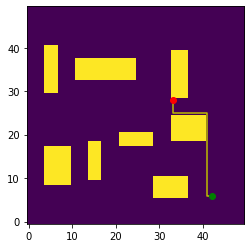

Number of steps taken in A* Path,  32


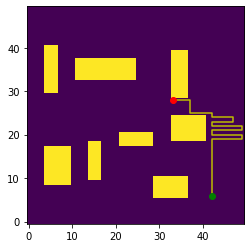

Number of steps taken in pred Path 70
1


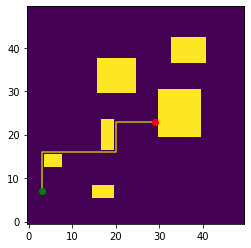

Number of steps taken in A* Path,  43


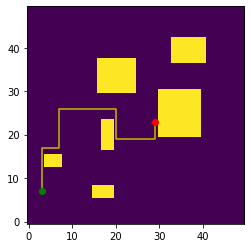

Number of steps taken in pred Path 57
1


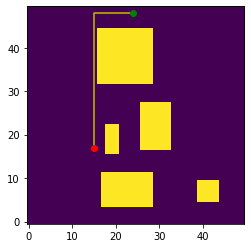

Number of steps taken in A* Path,  41


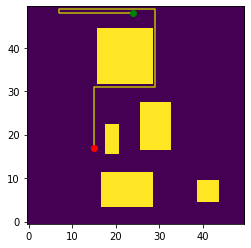

Number of steps taken in pred Path 87
1


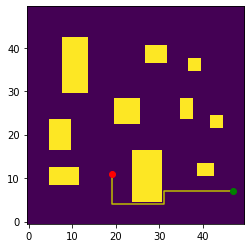

Number of steps taken in A* Path,  39


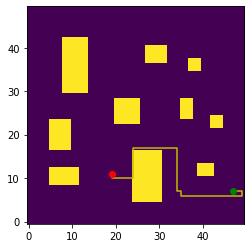

Number of steps taken in pred Path 53
0


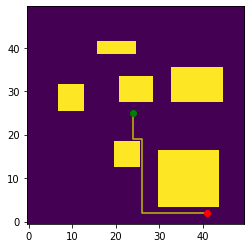

Number of steps taken in A* Path,  41


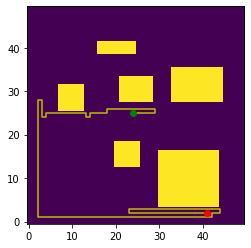

Number of steps taken in pred Path 153
1


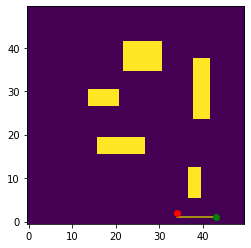

Number of steps taken in A* Path,  11


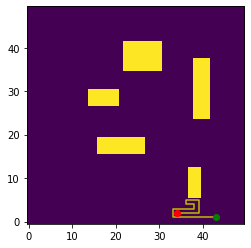

Number of steps taken in pred Path 33
1


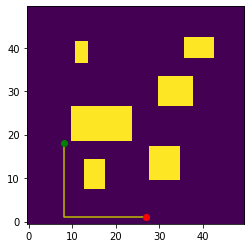

Number of steps taken in A* Path,  37


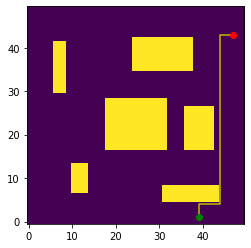

Number of steps taken in A* Path,  51


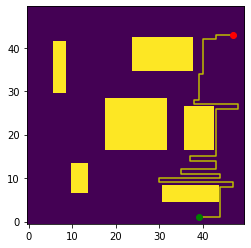

Number of steps taken in pred Path 135
1


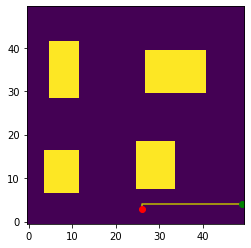

Number of steps taken in A* Path,  25


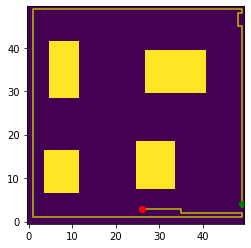

Number of steps taken in pred Path 217
1


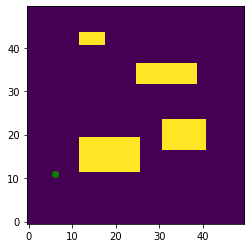

Number of steps taken in A* Path,  1


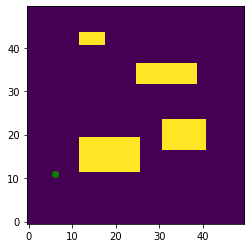

Number of steps taken in pred Path 1
0


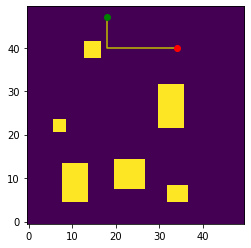

Number of steps taken in A* Path,  24


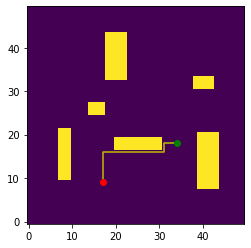

Number of steps taken in A* Path,  27


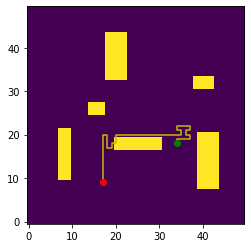

Number of steps taken in pred Path 51
0


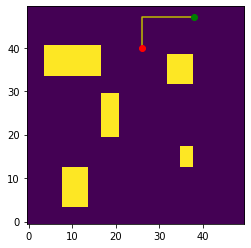

Number of steps taken in A* Path,  20


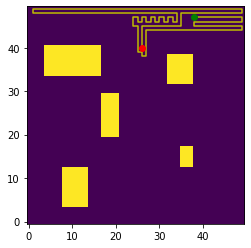

Number of steps taken in pred Path 212
1


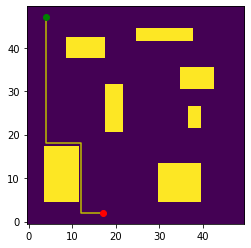

Number of steps taken in A* Path,  59


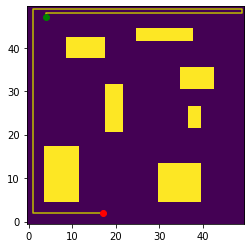

Number of steps taken in pred Path 159
1


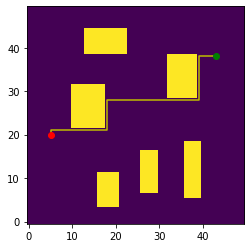

Number of steps taken in A* Path,  57


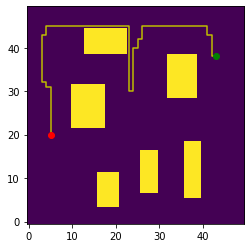

Number of steps taken in pred Path 105
1


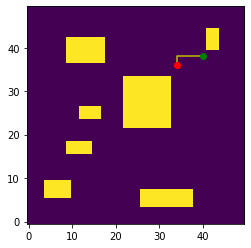

Number of steps taken in A* Path,  9


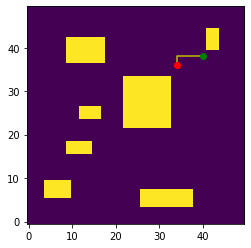

Number of steps taken in pred Path 9
1


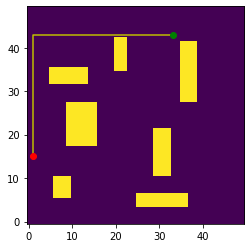

Number of steps taken in A* Path,  61


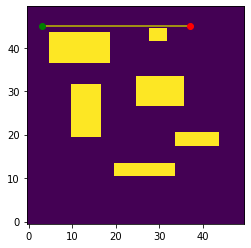

Number of steps taken in A* Path,  35


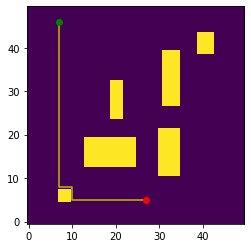

Number of steps taken in A* Path,  62


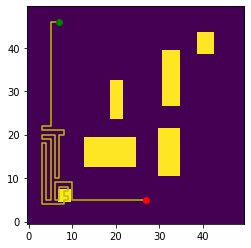

Number of steps taken in pred Path 154
0


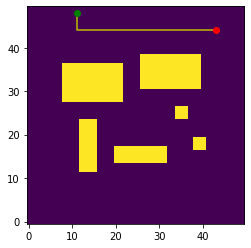

Number of steps taken in A* Path,  37


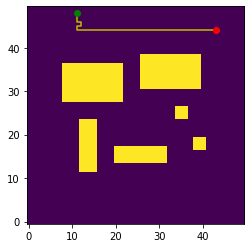

Number of steps taken in pred Path 39
1


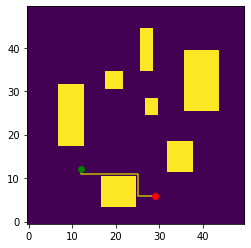

Number of steps taken in A* Path,  24


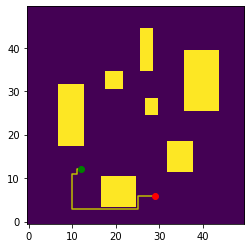

Number of steps taken in pred Path 34
1


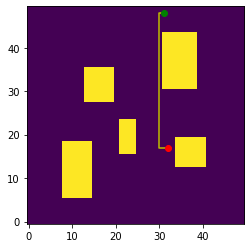

Number of steps taken in A* Path,  35


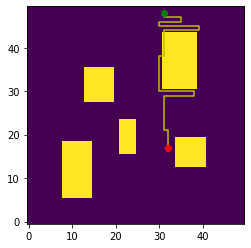

Number of steps taken in pred Path 75
0


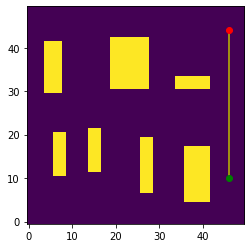

Number of steps taken in A* Path,  35


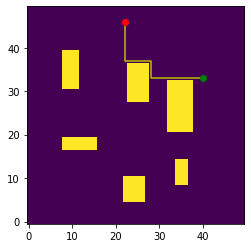

Number of steps taken in A* Path,  32


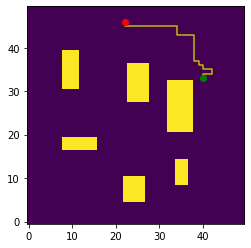

Number of steps taken in pred Path 36
1


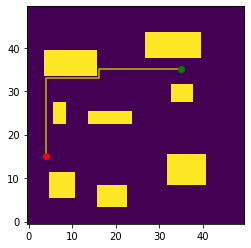

Number of steps taken in A* Path,  52


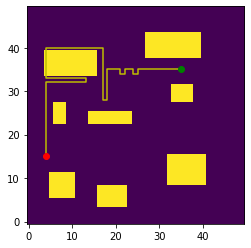

Number of steps taken in pred Path 98
0


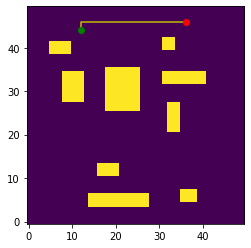

Number of steps taken in A* Path,  27


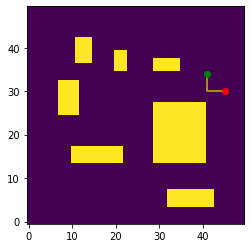

Number of steps taken in A* Path,  9


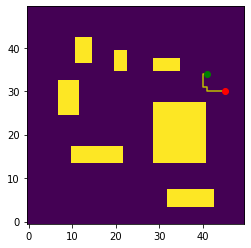

Number of steps taken in pred Path 11
1


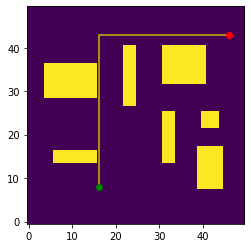

Number of steps taken in A* Path,  66


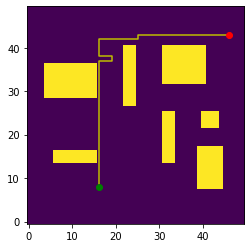

Number of steps taken in pred Path 72
1


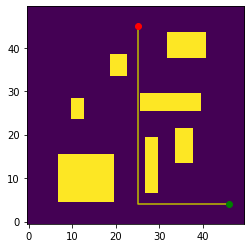

Number of steps taken in A* Path,  63


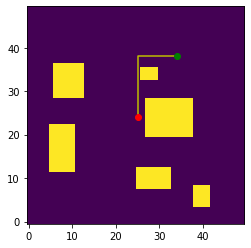

Number of steps taken in A* Path,  24


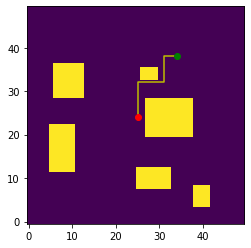

Number of steps taken in pred Path 24
1


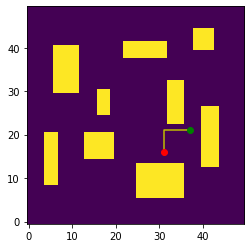

Number of steps taken in A* Path,  12


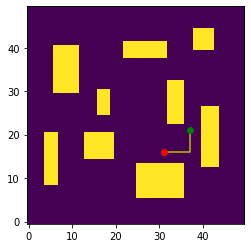

Number of steps taken in pred Path 12
1


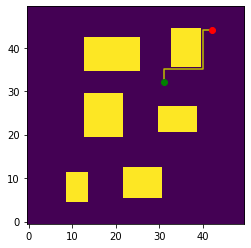

Number of steps taken in A* Path,  24


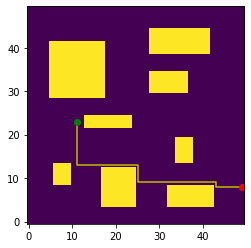

Number of steps taken in A* Path,  54


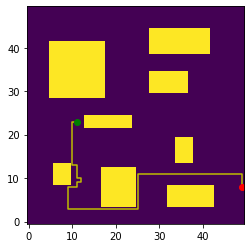

Number of steps taken in pred Path 78
1


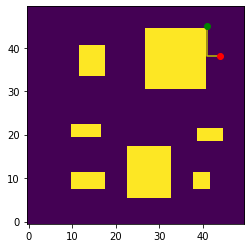

Number of steps taken in A* Path,  11


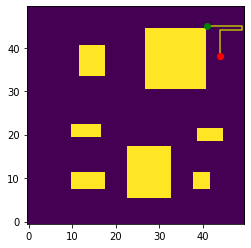

Number of steps taken in pred Path 21
1


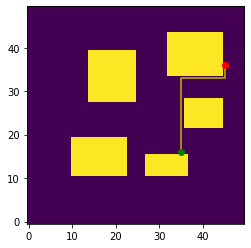

Number of steps taken in A* Path,  31


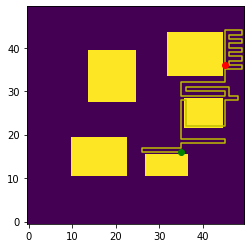

Number of steps taken in pred Path 177
0


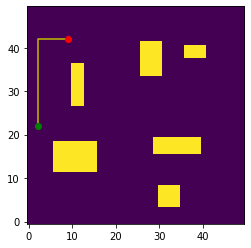

Number of steps taken in A* Path,  28


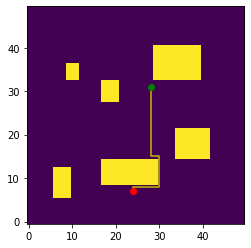

Number of steps taken in A* Path,  33


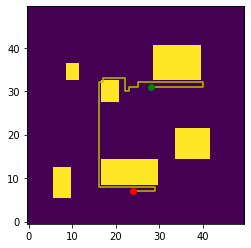

Number of steps taken in pred Path 87
0


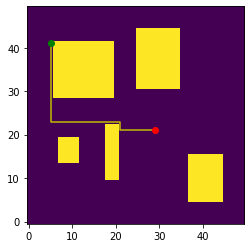

Number of steps taken in A* Path,  45


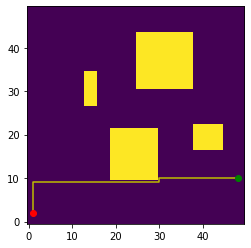

Number of steps taken in A* Path,  56


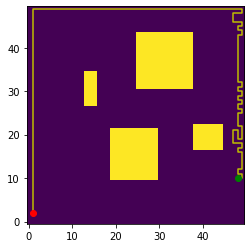

Number of steps taken in pred Path 164
1


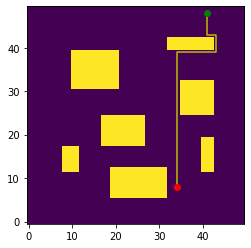

Number of steps taken in A* Path,  52


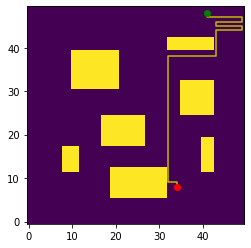

Number of steps taken in pred Path 80
1


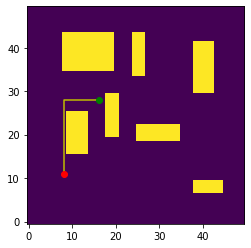

Number of steps taken in A* Path,  26


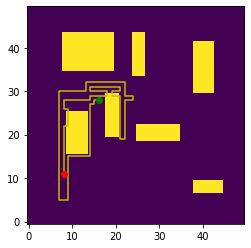

Number of steps taken in pred Path 152
0


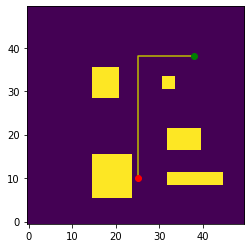

Number of steps taken in A* Path,  42


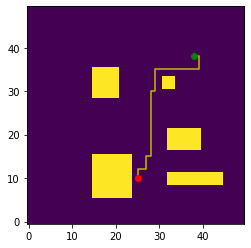

Number of steps taken in pred Path 44
1


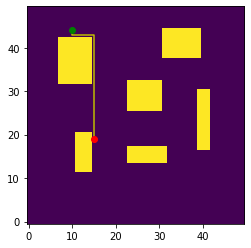

Number of steps taken in A* Path,  31


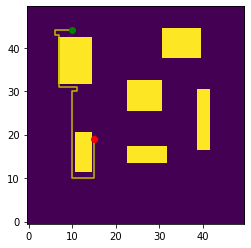

Number of steps taken in pred Path 59
0


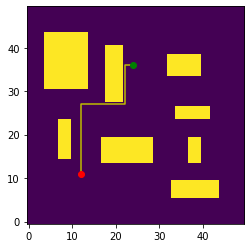

Number of steps taken in A* Path,  38


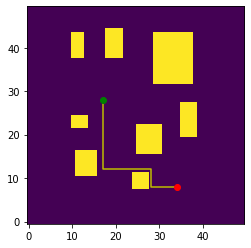

Number of steps taken in A* Path,  38


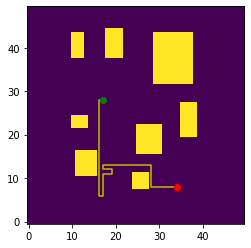

Number of steps taken in pred Path 58
1


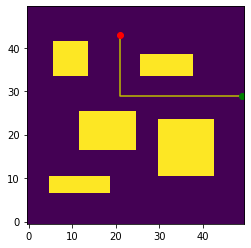

Number of steps taken in A* Path,  43


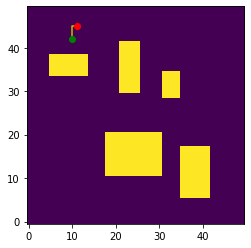

Number of steps taken in A* Path,  5


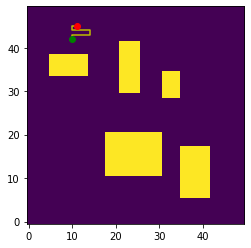

Number of steps taken in pred Path 13
1


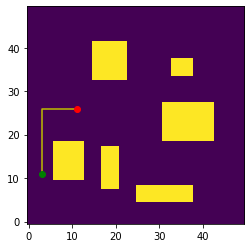

Number of steps taken in A* Path,  24


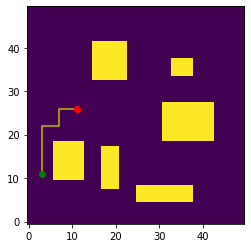

Number of steps taken in pred Path 24
1


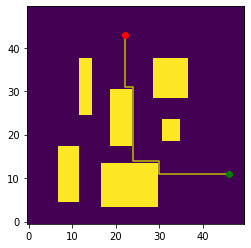

Number of steps taken in A* Path,  57


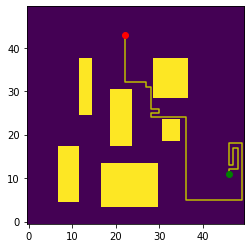

Number of steps taken in pred Path 105
1


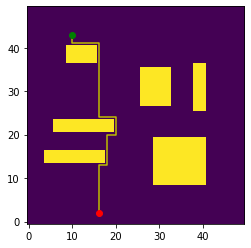

Number of steps taken in A* Path,  56


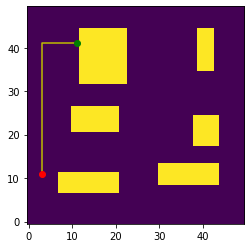

Number of steps taken in A* Path,  39


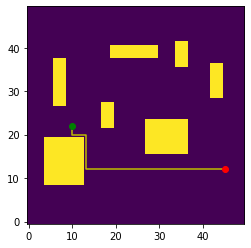

Number of steps taken in A* Path,  46


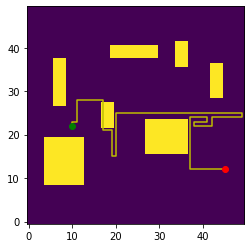

Number of steps taken in pred Path 112
0


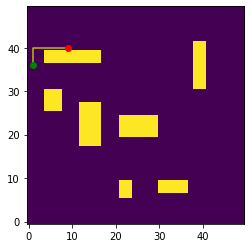

Number of steps taken in A* Path,  13


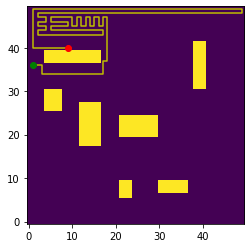

Number of steps taken in pred Path 227
1


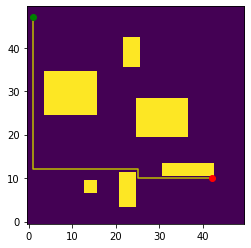

Number of steps taken in A* Path,  79


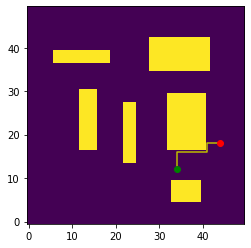

Number of steps taken in A* Path,  17


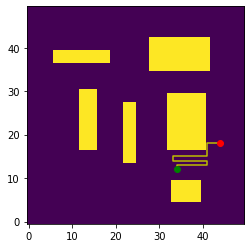

Number of steps taken in pred Path 33
1


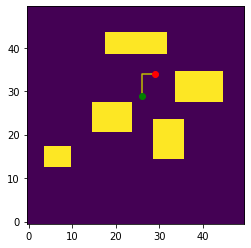

Number of steps taken in A* Path,  9


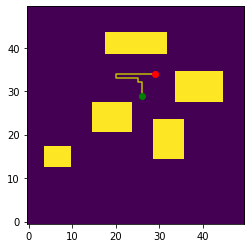

Number of steps taken in pred Path 21
1


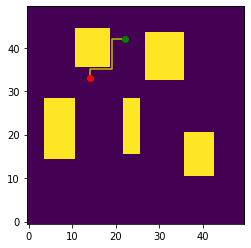

Number of steps taken in A* Path,  18


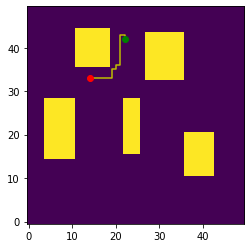

Number of steps taken in pred Path 20
1


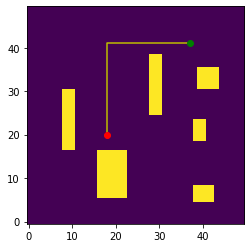

Number of steps taken in A* Path,  41


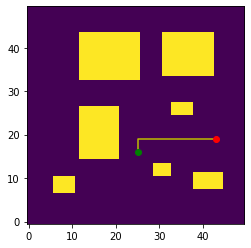

Number of steps taken in A* Path,  22


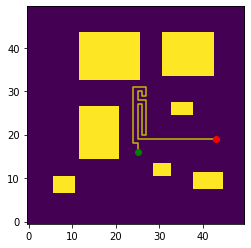

Number of steps taken in pred Path 72
1


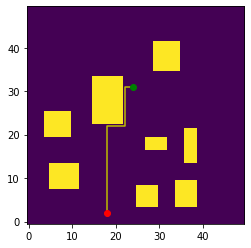

Number of steps taken in A* Path,  36


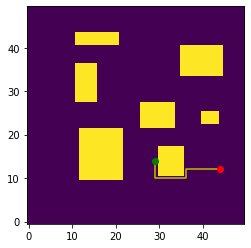

Number of steps taken in A* Path,  22


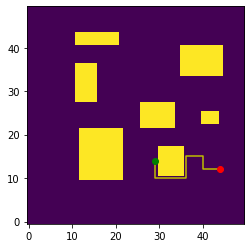

Number of steps taken in pred Path 28
1


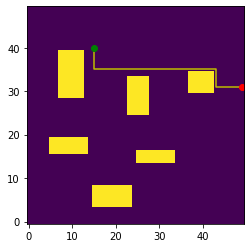

Number of steps taken in A* Path,  44


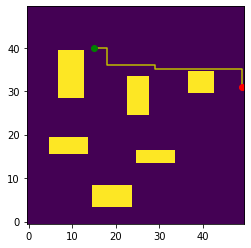

Number of steps taken in pred Path 44
1


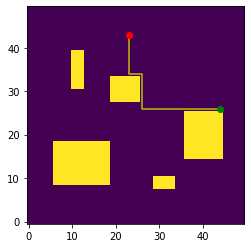

Number of steps taken in A* Path,  39


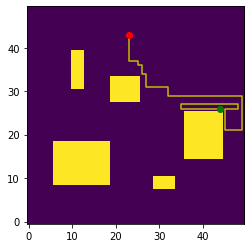

Number of steps taken in pred Path 85
1


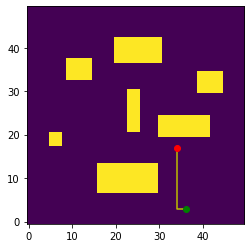

Number of steps taken in A* Path,  17


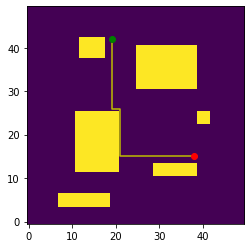

Number of steps taken in A* Path,  47


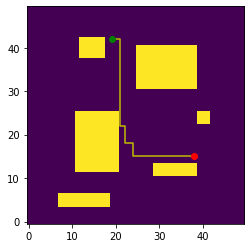

Number of steps taken in pred Path 47
1


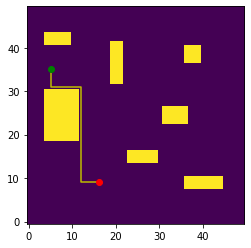

Number of steps taken in A* Path,  38


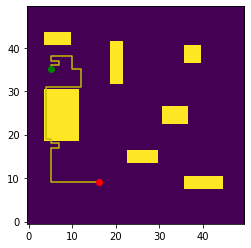

Number of steps taken in pred Path 68
0


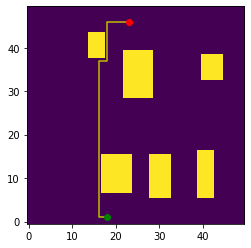

Number of steps taken in A* Path,  55


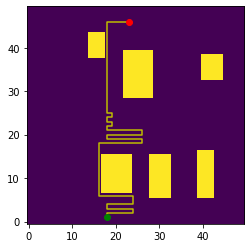

Number of steps taken in pred Path 115
1


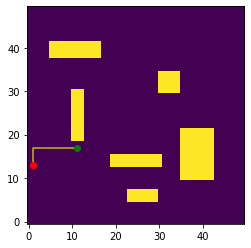

Number of steps taken in A* Path,  15


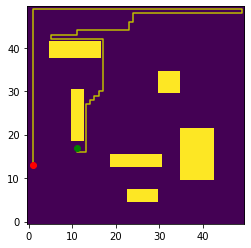

Number of steps taken in pred Path 181
1


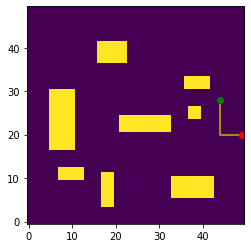

Number of steps taken in A* Path,  14


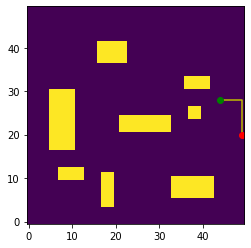

Number of steps taken in pred Path 14
1


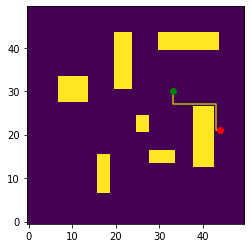

Number of steps taken in A* Path,  21


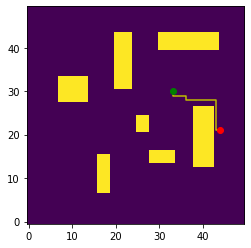

Number of steps taken in pred Path 21
1


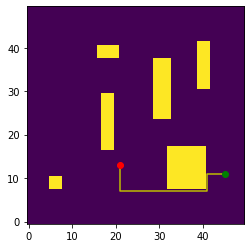

Number of steps taken in A* Path,  35


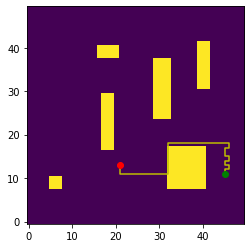

Number of steps taken in pred Path 47
0


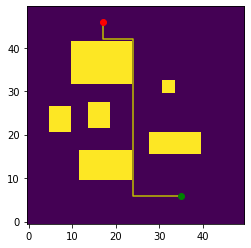

Number of steps taken in A* Path,  59


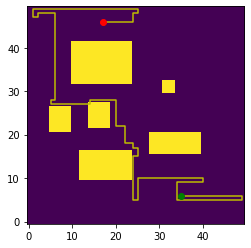

Number of steps taken in pred Path 173
0


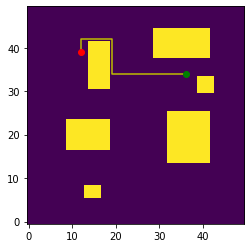

Number of steps taken in A* Path,  36


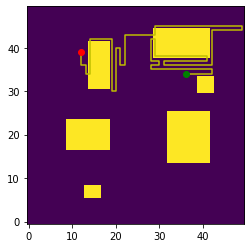

Number of steps taken in pred Path 174
0


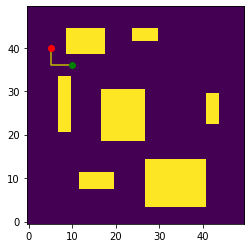

Number of steps taken in A* Path,  10


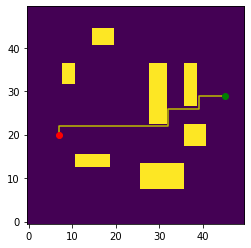

Number of steps taken in A* Path,  48


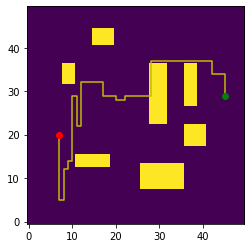

Number of steps taken in pred Path 116
0


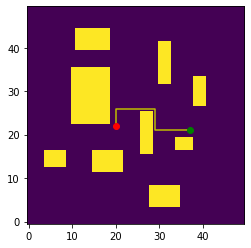

Number of steps taken in A* Path,  27


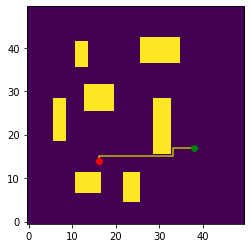

Number of steps taken in A* Path,  26


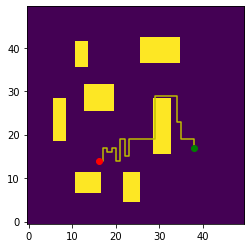

Number of steps taken in pred Path 66
0


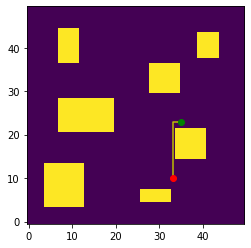

Number of steps taken in A* Path,  16


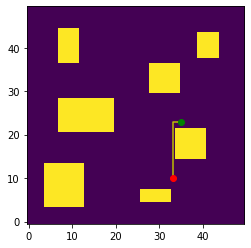

Number of steps taken in pred Path 16
1


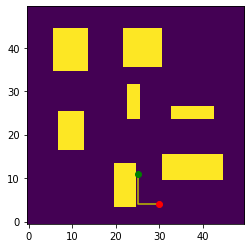

Number of steps taken in A* Path,  13


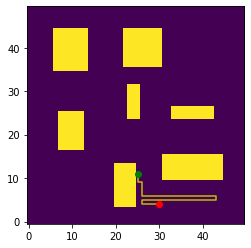

Number of steps taken in pred Path 47
1


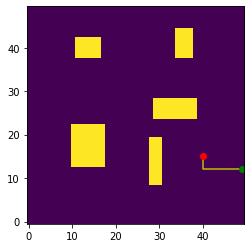

Number of steps taken in A* Path,  13


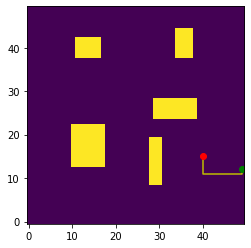

Number of steps taken in pred Path 15
1


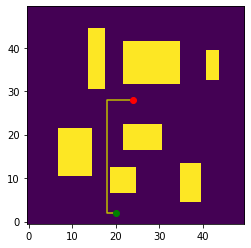

Number of steps taken in A* Path,  35


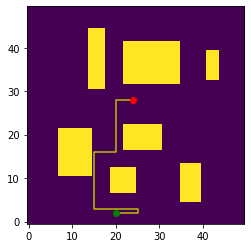

Number of steps taken in pred Path 51
1


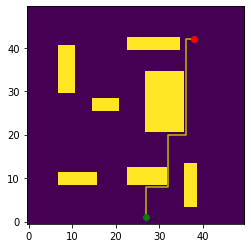

Number of steps taken in A* Path,  53


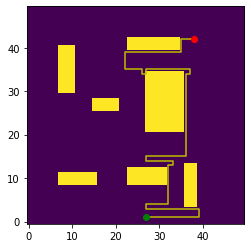

Number of steps taken in pred Path 121
0


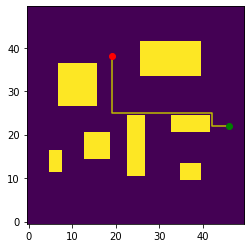

Number of steps taken in A* Path,  44


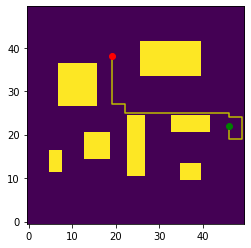

Number of steps taken in pred Path 56
1


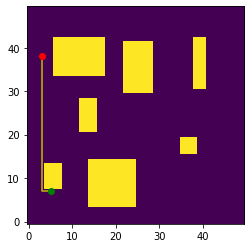

Number of steps taken in A* Path,  34


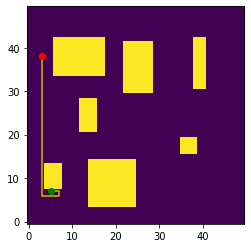

Number of steps taken in pred Path 40
1


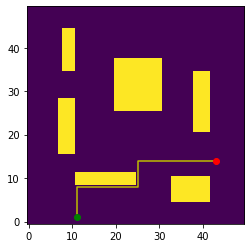

Number of steps taken in A* Path,  46


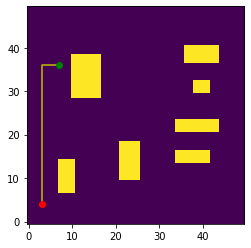

Number of steps taken in A* Path,  37


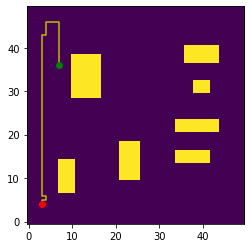

Number of steps taken in pred Path 59
1


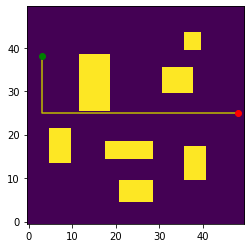

Number of steps taken in A* Path,  59


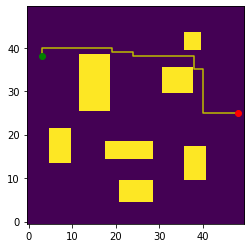

Number of steps taken in pred Path 63
1


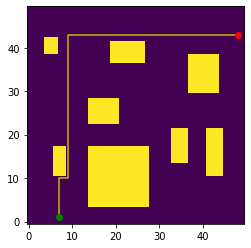

Number of steps taken in A* Path,  84


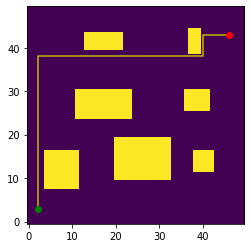

Number of steps taken in A* Path,  85


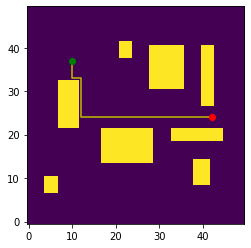

Number of steps taken in A* Path,  46


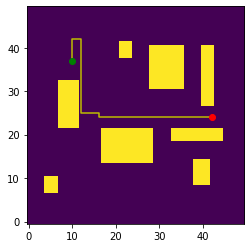

Number of steps taken in pred Path 56
1


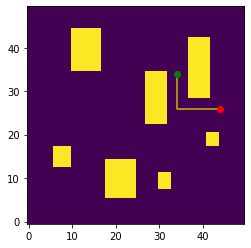

Number of steps taken in A* Path,  19


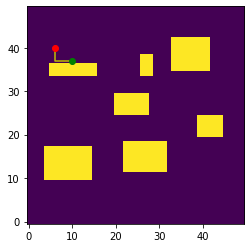

Number of steps taken in A* Path,  8


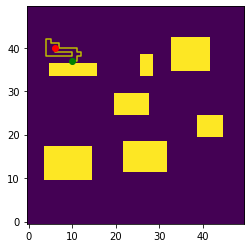

Number of steps taken in pred Path 32
1


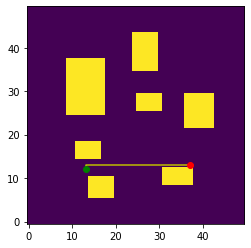

Number of steps taken in A* Path,  26


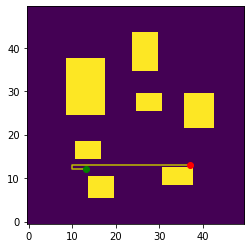

Number of steps taken in pred Path 32
1


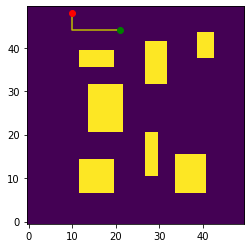

Number of steps taken in A* Path,  16


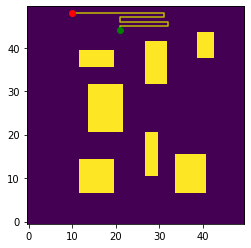

Number of steps taken in pred Path 58
1


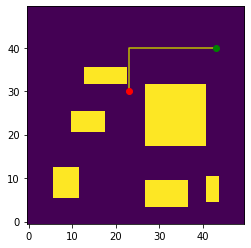

Number of steps taken in A* Path,  31


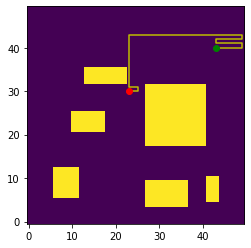

Number of steps taken in pred Path 65
1


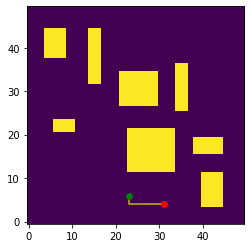

Number of steps taken in A* Path,  11


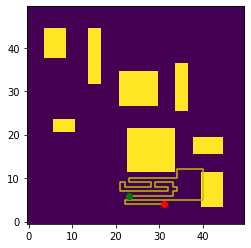

Number of steps taken in pred Path 107
0


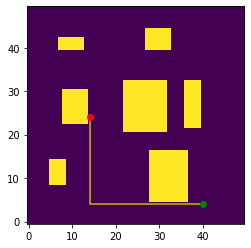

Number of steps taken in A* Path,  47


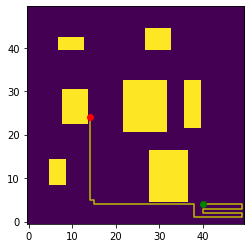

Number of steps taken in pred Path 89
1


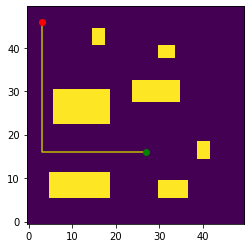

Number of steps taken in A* Path,  55


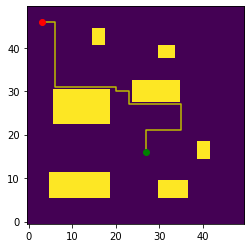

Number of steps taken in pred Path 71
1


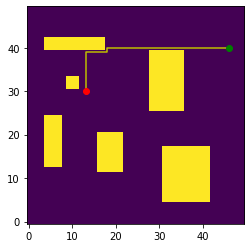

Number of steps taken in A* Path,  44


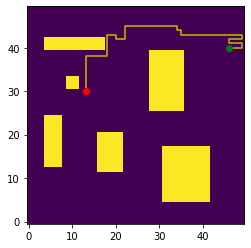

Number of steps taken in pred Path 68
1


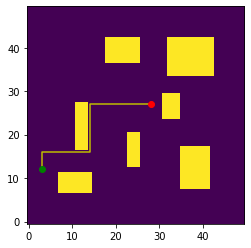

Number of steps taken in A* Path,  41


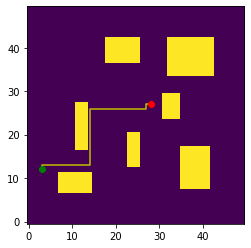

Number of steps taken in pred Path 41
1


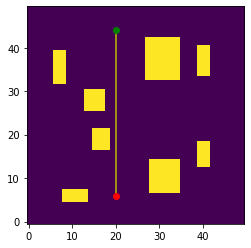

Number of steps taken in A* Path,  39


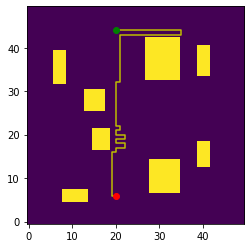

Number of steps taken in pred Path 81
1


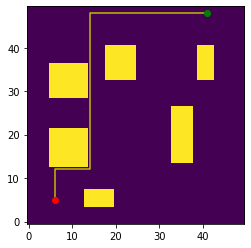

Number of steps taken in A* Path,  79


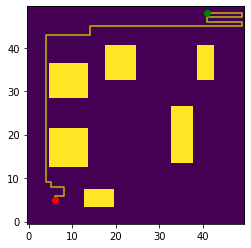

Number of steps taken in pred Path 119
1


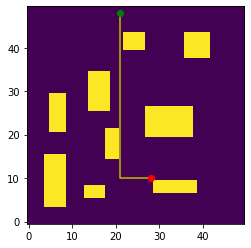

Number of steps taken in A* Path,  46


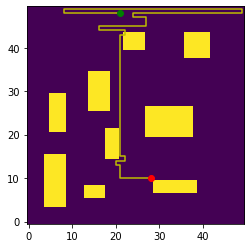

Number of steps taken in pred Path 152
0


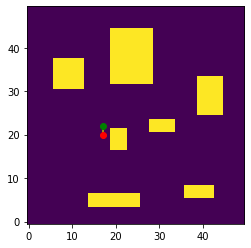

Number of steps taken in A* Path,  3


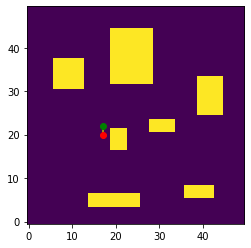

Number of steps taken in pred Path 3
1


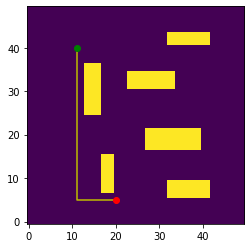

Number of steps taken in A* Path,  45


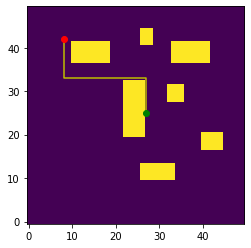

Number of steps taken in A* Path,  37


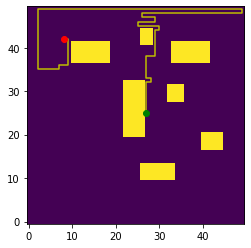

Number of steps taken in pred Path 141
1


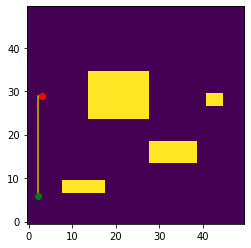

Number of steps taken in A* Path,  25


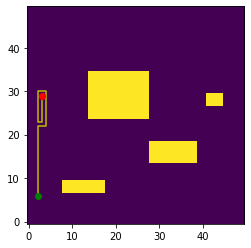

Number of steps taken in pred Path 43
1


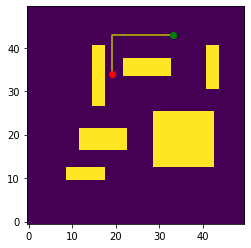

Number of steps taken in A* Path,  24


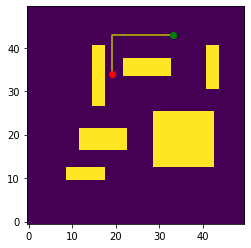

Number of steps taken in pred Path 24
1


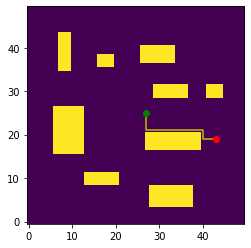

Number of steps taken in A* Path,  23


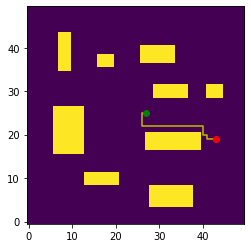

Number of steps taken in pred Path 25
1


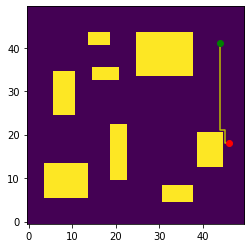

Number of steps taken in A* Path,  26


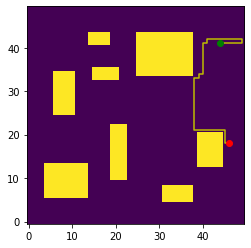

Number of steps taken in pred Path 50
1


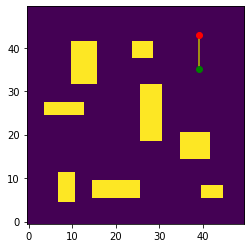

Number of steps taken in A* Path,  9


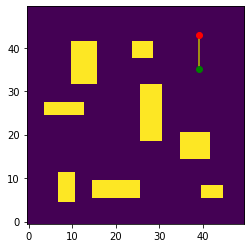

Number of steps taken in pred Path 9
1


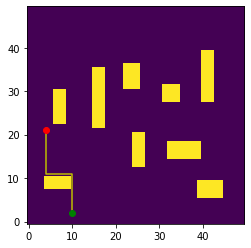

Number of steps taken in A* Path,  26


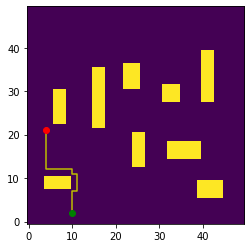

Number of steps taken in pred Path 28
1


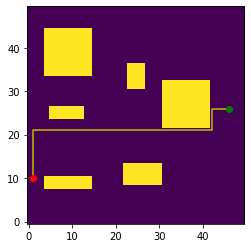

Number of steps taken in A* Path,  62


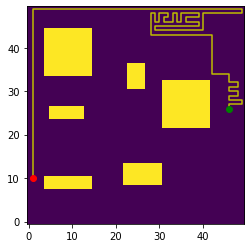

Number of steps taken in pred Path 212
1


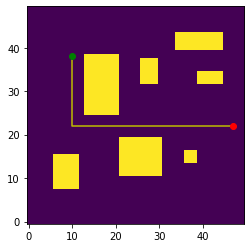

Number of steps taken in A* Path,  54


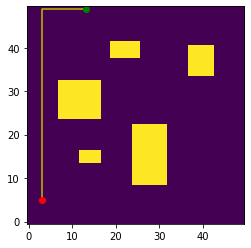

Number of steps taken in A* Path,  55


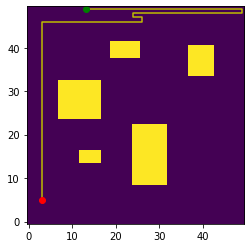

Number of steps taken in pred Path 131
1


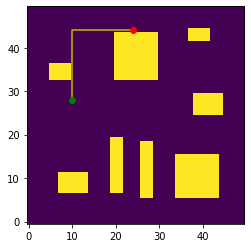

Number of steps taken in A* Path,  31


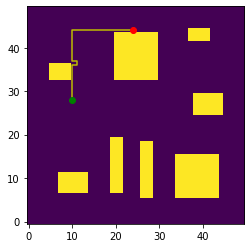

Number of steps taken in pred Path 33
1


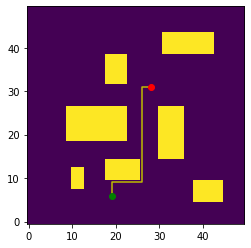

Number of steps taken in A* Path,  35


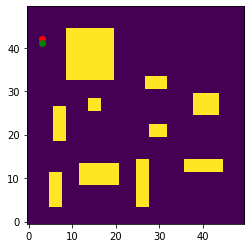

Number of steps taken in A* Path,  2


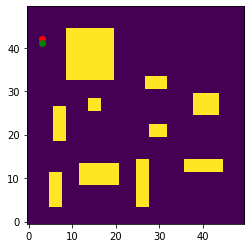

Number of steps taken in pred Path 2
1


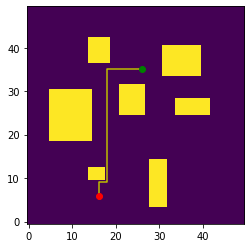

Number of steps taken in A* Path,  40


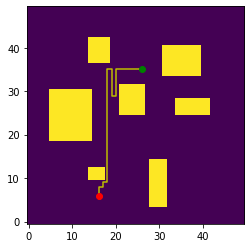

Number of steps taken in pred Path 52
1


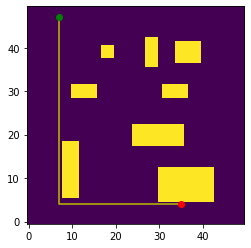

Number of steps taken in A* Path,  72


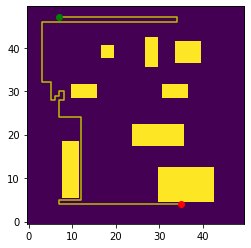

Number of steps taken in pred Path 150
1


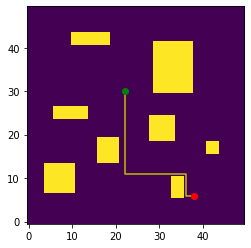

Number of steps taken in A* Path,  41


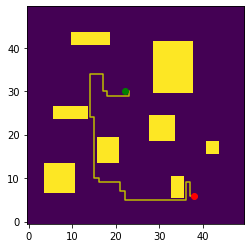

Number of steps taken in pred Path 77
1


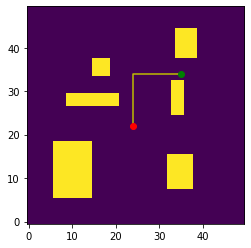

Number of steps taken in A* Path,  24


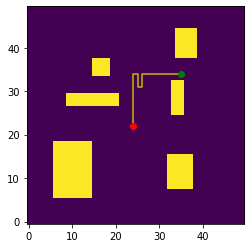

Number of steps taken in pred Path 30
1


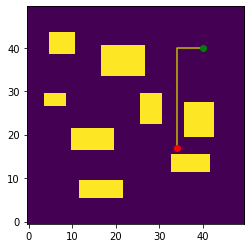

Number of steps taken in A* Path,  30


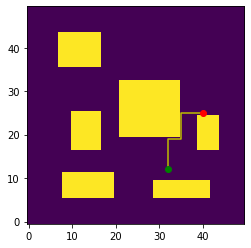

Number of steps taken in A* Path,  22


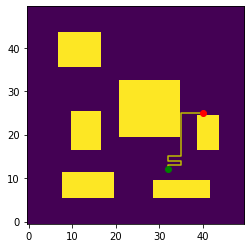

Number of steps taken in pred Path 28
1


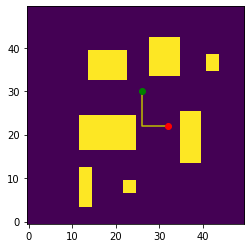

Number of steps taken in A* Path,  15


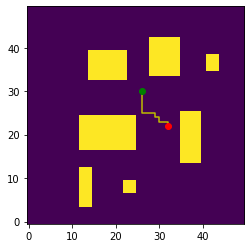

Number of steps taken in pred Path 15
1


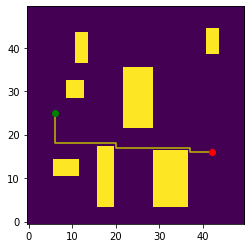

Number of steps taken in A* Path,  46


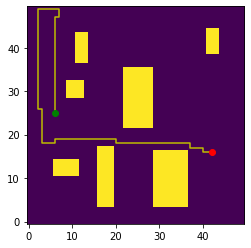

Number of steps taken in pred Path 106
1


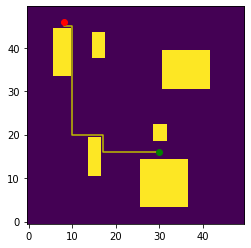

Number of steps taken in A* Path,  53


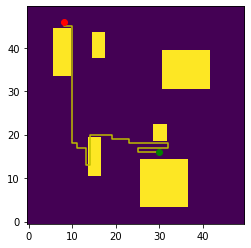

Number of steps taken in pred Path 81
0


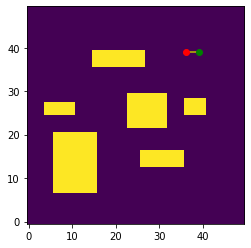

Number of steps taken in A* Path,  4


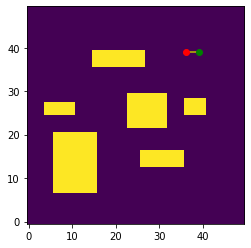

Number of steps taken in pred Path 4
1
79 -33.46835443037975


In [58]:
# Test
pred_len = []
astar_len = []
n_test = 0
map_size = (50,50)
successes = 0
avgs = []
while n_test < 100:
    # TODO: Generalize to any map shape
    start = (random.randint(1,49), random.randint(1,49))
    goal = (random.randint(1,49), random.randint(1,49))
    arr, test_MAP = placeRandomRooms(map_size, minRoomSize=3, maxRoomSize=15, roomStep = 1, margin = 4, attempts = 100)
    try:
        pred_path, dirs, success, ground_truth = test_omni(test_MAP, arr, start, goal, clf)
        OccupancyGridMap(arr, 1).plot()
        plot_path(pred_path)
        pred_len.append(len(pred_path))
        print('Number of steps taken in pred Path', len(pred_path))
        astar_len.append(len(get_path(start, goal, arr, False)))
        n_test += 1
        successes += success
        print(success)
        if success == 1:
            avgs.append(len(ground_truth) - len(pred_path))
#     break
    except:
        continue

print(successes, np.mean(avgs))

In [ ]:
print(successes)

In [ ]:
marker_dict = {0:">", np.pi/2:"^", np.pi:"<", 3*np.pi/2:"v"}

import imageio
# dirs = [(float(int(a)), float(int(b))) for (a,b) in dirs]
# print(dirs)
def plot_path_with_lines(pred_path, MAP):
    '''
    Given predicted path nodes and map, 
    plot the path and the sensor readings for each node
    '''
    # Update node positions for shapely plotting

    pred_path = [(p[0]+0.5, p[1]+0.5) for p in pred_path]
    # Save filenames for GIF creation
    filenames=[]
    offset=0
    for i, node in enumerate(pred_path):
        # Create fig
        fig = plt.figure(frameon=False)
        fig.set_size_inches(15,10)
        plt.plot(*LineString(pred_path).xy)
        
        if dirs[i] != (0, 0):
            offset = inv_dirs[dirs[i]]
        rot = np.pi/2 * offset 
        plt.scatter(*node, s=100, alpha=1.0, marker = marker_dict[rot])

        distances, lines = synthetic_sensor(MAP, node, dirs[i])
        for index, l in enumerate(MAP): 
            if index != 0:
                plt.fill(*l.xy, alpha=1)
            else:
                plt.plot(*l.xy, alpha=1)
        for k, line in enumerate(lines):
            plt.plot(*line.xy, alpha=0.25)

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        
        origin = -1*offset 
        front_dist = str(distances[0])
        left_dist = str(distances[1])
        right_dist = str(distances[-1])
        textstr = '\n'.join(['straight dist = {}'.format(front_dist),
                            'left dist = {}'.format(left_dist),
                            'right dist = {}'.format(right_dist)])

#         ds = [str(d) for d in distances]
#         textstr = '\n'.join(ds)
        plt.text(-5,-5, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

        filenames.append('img_{}.png'.format(i))
        plt.savefig('img_{}.png'.format(i))
        plt.close()
    
    # Make GIF
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('demo.gif', images)
        
plot_path_with_lines(pred_path[:-1], test_MAP)

In [ ]:
from IPython.display import Image
Image('demo.gif')

In [ ]:
inv_dirs

In [ ]:
direction = (-1.0, 0.0)
distances = [1,2,3,4]
if direction != (0, 0): # Start node
    offset = int(len(distances) / 4.) * inv_dirs[direction]
    distances = distances[offset:] + distances[:offset] 
    
print(distances)

In [ ]:
distances = [1,2,3,4]

In [ ]:
distances[-2]